
[시계열 예측 2: 평가 및 종합 실습]에 대한 실습 노트북이다.

이 시간의 핵심은 "모델이 뱉어낸 예측값을 무작정 믿지 말고, 검증하는 습관"을 기르는 것이다. 과거의 데이터를 가리고 예측해본 뒤 실제와 비교하는 과정을 통해 모델의 신뢰도를 평가한다.

---

# 📘 예측 모델 채점하기: 평가와 해석

## 1. 예측 모델을 평가해야 하는 이유
*   Prophet 모델이 "내일 환자가 100명 올 거야"라고 했다. 이 말을 믿고 간호사를 배치해도 될까?
*   예측 모델은 언제나 틀릴 수 있다. 중요한 건 "얼마나 틀리는지"를 알고, 그 오차 범위를 감안해서 의사결정을 내리는 것이다.

## 2. 평가 방법: 타임머신 타기 (Train-Test Split)
미래 데이터는 아직 없으므로 평가할 수 없다. 그래서 우리는 과거 데이터의 일부를 '미래인 척' 따로 떼어놓고 테스트한다.

1.  학습 데이터 (Train Set): 과거 ~ 2024년 11월 (모델에게 공부시키는 용도)
2.  평가 데이터 (Test Set): 2024년 12월 (모델에게 보여주지 않고 정답지로 숨겨둠)
3.  검증: 모델이 11월까지의 데이터만 보고 12월을 예측하게 한 뒤, 실제 12월 데이터와 맞춰본다.

## 3. 평가 지표 (Metrics): 점수 매기기
오차(Error)를 수치화하는 두 가지 대표적인 방법이다.

1.  MAE (Mean Absolute Error, 평균 절대 오차):
    *   $|실제값 - 예측값|$의 평균.
    *   *직관적 해석:* "우리 모델은 평균적으로 $\pm$ 5명 정도 틀린다."
    *   가장 이해하기 쉽고 설명하기 좋다.
2.  RMSE (Root Mean Squared Error, 평균 제곱근 오차):
    *   오차를 제곱해서 평균 낸 뒤 루트를 씌운다.
    *   *특징:* 큰 오차(Blunder)에 더 큰 벌점을 준다. 5만큼 10번 틀린 것보다, 50만큼 1번 틀린 것을 더 나쁘게 평가한다.
    *   갑작스러운 환자 폭증을 놓치면 안 되는 헬스케어 분야에서 중요하게 본다.

## 4. 모델의 해석 (Interpretation)
Prophet의 강력한 기능인 컴포넌트(Components) 분석을 통해 인사이트를 도출한다.
*   Trend: "우리 병원 환자가 장기적으로 늘고 있는가, 줄고 있는가?"
*   Weekly: "주말 근무표를 어떻게 짜야 하는가?" (토요일 피크 확인)
*   Yearly: "백신 재고를 언제 확보해야 하는가?" (계절적 피크 확인)

---
---

# 💻 예측 모델 성능 평가 및 인사이트 도출

이 노트북에서는 데이터를 학습용(Train)과 테스트용(Test)으로 나누어 실전과 같은 예측 시뮬레이션을 수행하고, 그 정확도를 평가 지표(MAE, RMSE)로 계산해본다.

### 1. 환경 설정 및 데이터 준비
nc_1_7과 동일한 가상의 응급실 데이터를 생성한다.

In [1]:
!pip install prophet scikit-learn

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 데이터 생성 (2년치: 2023-01-01 ~ 2024-12-31)
dates = pd.date_range(start='2023-01-01', periods=730, freq='D')

np.random.seed(42)
# 추세 + 주간 계절성 + 연간 계절성 + 노이즈 복합
y = (
    50 +                                         # 기본 베이스
    np.arange(len(dates)) * 0.05 +               # Trend: 완만한 증가
    10 * np.isin(dates.dayofweek, [5, 6]) +      # Weekly: 주말(5,6)에 10명 증가
    15 * np.sin(2 * np.pi * dates.dayofyear / 365.25) + # Yearly: 계절성
    np.random.normal(0, 3, len(dates))           # Noise
)

df = pd.DataFrame({'ds': dates, 'y': y})

print("전체 데이터 크기:", df.shape)
display(df.tail())

전체 데이터 크기: (730, 2)


,ds,y
725,2024-12-26,84.602372
726,2024-12-27,85.517120
727,2024-12-28,96.812308
728,2024-12-29,94.458200
729,2024-12-30,84.050577


### 2. 데이터 분할 (Train / Test Split)
마지막 30일(한 달)을 테스트용으로 떼어놓는다. 모델은 이 30일의 데이터를 절대 봐서는 안 된다.

학습 데이터 기간: 2023-01-01 ~ 2024-11-30 (700일)
평가 데이터 기간: 2024-12-01 ~ 2024-12-30 (30일)


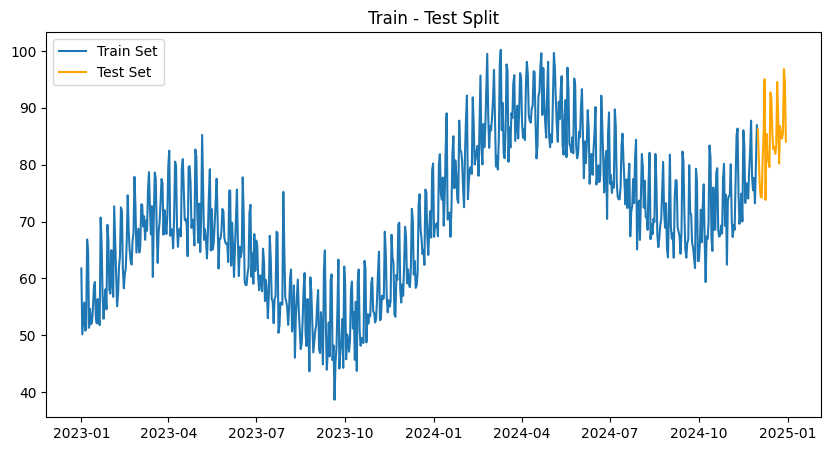

In [2]:
# 마지막 30일을 기준으로 분할
test_days = 30
train_df = df.iloc[:-test_days]  # 처음 ~ 마지막 30일 전까지
test_df = df.iloc[-test_days:]   # 마지막 30일

print(f"학습 데이터 기간: {train_df['ds'].min().date()} ~ {train_df['ds'].max().date()} ({len(train_df)}일)")
print(f"평가 데이터 기간: {test_df['ds'].min().date()} ~ {test_df['ds'].max().date()} ({len(test_df)}일)")

# 시각화로 분할 영역 확인
plt.figure(figsize=(10, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train Set')
plt.plot(test_df['ds'], test_df['y'], label='Test Set', color='orange')
plt.title("Train - Test Split")
plt.legend()
plt.show()

### 3. 모델 학습 및 예측
`train_df`만 사용하여 모델을 학습시키고, `test_df` 기간에 대해 예측을 수행한다.

In [3]:
# 1. 모델 생성 및 학습
model = Prophet()
model.fit(train_df) # Test 데이터는 보여주지 않음!

# 2. 미래 데이터프레임 생성 (Test 기간인 30일만큼)
future = model.make_future_dataframe(periods=test_days)

# 3. 예측 수행
forecast = model.predict(future)

# 예측 결과 중 Test 기간에 해당하는 부분만 추출
# forecast의 끝부분 30개가 Test 기간에 해당함
forecast_test = forecast.iloc[-test_days:]

print("Test 기간 예측 완료.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test 기간 예측 완료.


### 4. 시각적 비교 (Actual vs Predicted)
그래프로 실제값(정답)과 예측값이 얼마나 겹치는지 확인한다.

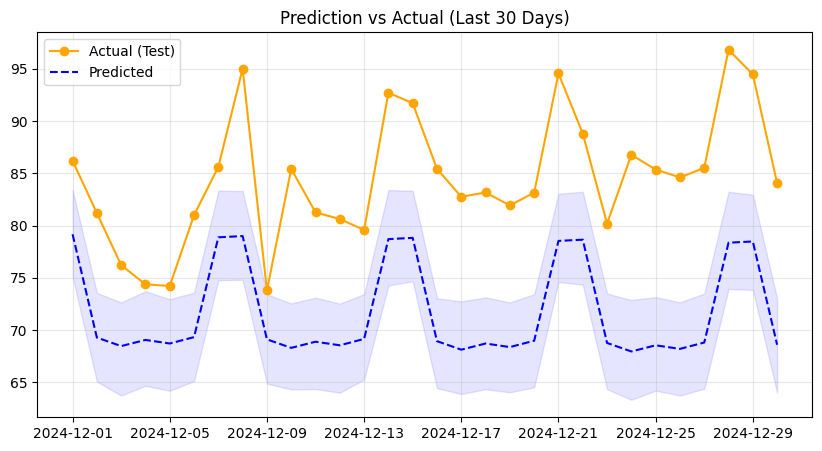

In [4]:
plt.figure(figsize=(10, 5))

# 실제값 (Test Set)
plt.plot(test_df['ds'], test_df['y'], label='Actual (Test)', marker='o', color='orange')

# 예측값 (Forecast)
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted', linestyle='--', color='blue')

# 신뢰구간 (불확실성)
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='blue', alpha=0.1)

plt.title("Prediction vs Actual (Last 30 Days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 해석: 파란 점선(예측)이 주황색 실선(실제)을 잘 따라가는지 확인한다.
# 주말마다 튀어 오르는 패턴을 잘 맞추고 있는지 확인한다.

### 5. 정량적 평가 (MAE, RMSE)
눈대중이 아니라 숫자로 정확도를 채점한다.

In [5]:
# 실제값과 예측값 가져오기
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

# 1. MAE (평균 절대 오차)
mae = mean_absolute_error(y_true, y_pred)

# 2. RMSE (평균 제곱근 오차)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=== 모델 성적표 ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 해석 출력
print(f"\n[해석] 이 모델은 일일 환자 수를 평균적으로 약 {mae:.1f}명 정도의 오차로 예측합니다.")

=== 모델 성적표 ===
MAE : 12.83
RMSE: 13.44

[해석] 이 모델은 일일 환자 수를 평균적으로 약 12.8명 정도의 오차로 예측합니다.


### 6. 컴포넌트 분석을 통한 인사이트 도출
Prophet이 찾아낸 데이터의 내부 구조를 뜯어보고 병원 운영 전략을 세운다.

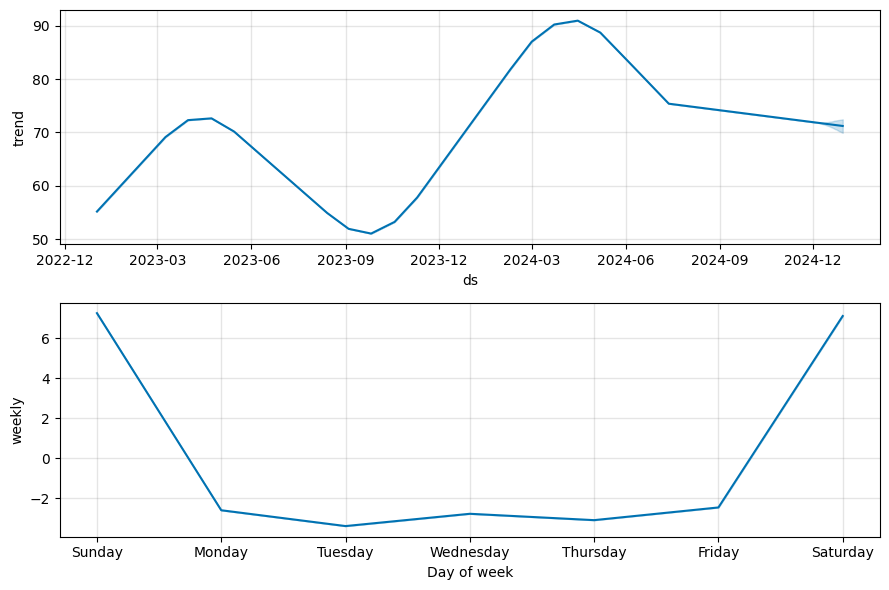

In [6]:
fig = model.plot_components(forecast)
plt.show()

# 그래프를 보고 아래와 같은 분석 리포트를 작성할 수 있어야 한다.

### 📝 종합 실습 리포트 작성 (예시)

[분석 결과 리포트]

1.  Trend (추세):
    *   그래프가 우상향하고 있다. 환자 수가 지속적으로 증가하는 추세이므로, 내년도 예산 편성 시 약품 및 소모품 발주량을 올해보다 늘려야 한다.
2.  Weekly (요일별):
    *   토요일/일요일에 그래프가 가장 높게 솟아있다.
    *   전략: 주말 근무 간호사 인력을 증원하거나, 파트타임 인력을 주말에 집중 배치해야 한다. 반면 수요일은 가장 한가하므로 연차 사용을 권장할 수 있다.
3.  Yearly (연간):
    *   그래프상 여름(7-8월)과 겨울(1-2월)에 피크가 있다.
    *   전략: 이 시기에는 휴가를 자제하고 비상 근무 체제를 준비해야 한다.

---

### 🎓 시계열 마무리
오늘 우리는 시계열 데이터의 기초(Index)부터 전처리(Resampling, Interpolation), 특성 추출(Rolling), 분해(Decomposition), 그리고 미래 예측(Prophet)까지 다루었다.

이 기술들은 환자의 바이탈 사인 모니터링부터 병원 경영 효율화까지 헬스케어의 거의 모든 영역에 적용될 수 있다. 내일(3일차)은 이 기술들을 종합하여 실제 데이터셋으로 프로젝트를 진행한다.